In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from numpy import ma
from scipy.special import logsumexp
import os
import time
import json
from matplotlib import pyplot as plt
from matplotlib import cm

from kernels_w_guarantees import kernels
from kernels_w_guarantees import seq_tools
from kernels_w_guarantees.stats_funcs import bootstrap_mat, lin_reg_error

First we define our kernels.
In this notebook we will look at the Hamming kernel with $L=2$
$$\tilde k(X, Y)=\sum_{l=0}^\infty 1(X_{(l:l+2)}=Y_{(l:l+2)}).$$
We will use the normalized tilting of this kernel $k(X, Y)=\tilde k(X, Y)/\sqrt{\tilde k(X, X)\tilde k(Y, Y)}$.
We will compare the Hamming kernel, which is not universal or characteristic, to the IMQ-H kernel, which has discrete masses:
$$k(X, Y)=(1+d_H(X, Y))^{-2}.$$
We will also look at the exponenetial Hamming kernel
$$k(X, Y)=\exp(-d_H(X, Y)/5).$$


In [2]:
kernel_ham = lambda x, y: kernels.hamming_ker_dot(x, y, lag=2)
kernel_imq = lambda x, y: kernels.hamming_ker_imq(x, y, scale=1, lag=1, beta=2)
kernel_exp = lambda x, y: kernels.hamming_ker_exp(x, y, bandwidth=5)

### Universality (Fig 1)

First we replicate Fig 1 of the paper, demonstrating the advantage of using kernels with discrete masses to learn functions.

In [3]:
# first we define our alphabet
alphabet_name = 'dna'
alphabet = seq_tools.alphabets_en[alphabet_name][:-1]
alphabet_size = len(alphabet)

# and define the function we wish to learn
def g(seqs):
    ohes = seq_tools.get_ohe(seqs)
    return np.max(np.sum(ohes, axis=-2), axis=-1)

In [4]:
# Next we generate our training and testing sequences
# by uniformly sampling sequences of length 10
seq_len = 4
n_train_seqs = 4000
n_test_seqs = 200
n_seqs = n_train_seqs + n_test_seqs
lag = 1

seqs = np.random.choice(alphabet, [n_seqs, seq_len])
seqs = [''.join(seq) for seq in seqs]
train_seqs = seqs[:n_train_seqs]
test_seqs = seqs[n_train_seqs:]

In [5]:
# we evaluate our function on our data and normalize
y_train = g(train_seqs)
y_test = g(test_seqs) - np.mean(y_train)
y_train = y_train - np.mean(y_train)
y_var = np.std(y_train)**2

In [6]:
# now we calcualte the kernel matrices
k_ham_xx = kernel_ham(train_seqs, train_seqs)
k_ham_yx = kernel_ham(test_seqs, train_seqs)
k_imq_xx = kernel_imq(train_seqs, train_seqs)
k_imq_yx = kernel_imq(test_seqs, train_seqs)

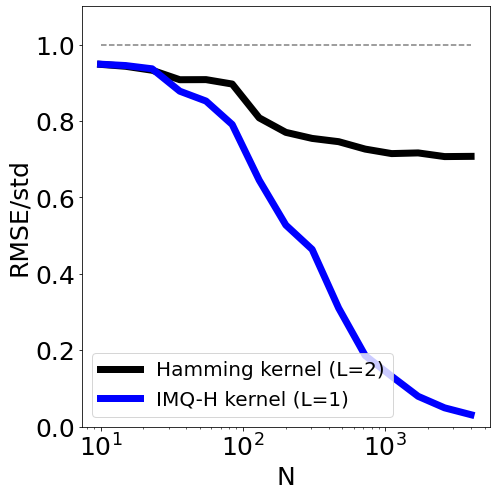

In [14]:
# now plot results

regularize = 2

models = [(k_ham_xx, k_ham_yx), (k_imq_xx, k_imq_yx)]
labels = ['Hamming kernel (L=2)', 'IMQ-H kernel (L=1)']
colors = ['black', 'blue',]

# ns = np.logspace(np.log10(10), np.log10(n_train_seqs), 15).astype(int)
# mses = np.zeros([len(models), len(ns)])
# for i, n in enumerate(ns):
#     for j, (k_xx, k_yx) in enumerate(models):
#         error = lin_reg_error(k_yx[:, :n], k_xx[:n, :n],
#                               y_train[:n], y_test, regularize=regularize)
#         mses[j, i] = error

plt.figure(figsize=[7, 7])
min_y = 1
for mse, label, color in zip(mses, labels, colors):
    plt.semilogx(ns, np.sqrt(mse/y_var),
                 label=label, color=color, lw=7)
plt.semilogx(ns, np.ones(len(ns)), color='grey', ls='--')
plt.xlabel("N", fontsize=25)
plt.ylabel("RMSE/std", fontsize=25)
plt.ylim(0, 1.1)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20, loc='lower left')
plt.tight_layout()

plt.show()
plt.close()

### Characteristicness (Fig 5)

Now we replicate Fig 5 of the paper, demonstrating the advantage of using kernels with discrete masses to distinguish distributions.

In [15]:
# first we define our alphabet
alphabet_name = 'dna'
alphabet = seq_tools.alphabets_en[alphabet_name][:-1]
alphabet_size = len(alphabet)

repetitions = 100
seq_len = 10
N = 90

all_seqs = np.random.choice(alphabet, [repetitions, 2 * N, seq_len])
all_seqs = np.array([[''.join(seq) for seq in r] for r in all_seqs])

# these are 100 sets of 200 uniformly samples sequences of length 10
unif_seqs = all_seqs[:, :N]
# these are 100 sets of 200 sequences whose first and last 5 letters are identical
repi_seqs = np.array([[s[:seq_len//2] + s[:seq_len//2] for s in r] for r in all_seqs])

In [16]:
# We calculate the kernel matrices
k_ham_xx_mats = []
k_ham_xy_mats = []
k_ham_yy_mats = []
k_imq_xx_mats = []
k_imq_xy_mats = []
k_imq_yy_mats = []
k_exp_xx_mats = []
k_exp_xy_mats = []
k_exp_yy_mats = []
for r, (unif_seqs_rep, repi_seqs_rep) in enumerate(zip(unif_seqs, repi_seqs)):
    print("Processing rep", r, '/', repetitions)
    k_ham_xx_mats.append(kernel_ham(unif_seqs_rep, unif_seqs_rep))
    k_ham_xy_mats.append(kernel_ham(unif_seqs_rep, repi_seqs_rep))
    k_ham_yy_mats.append(kernel_ham(repi_seqs_rep, repi_seqs_rep))
    k_imq_xx_mats.append(kernel_imq(unif_seqs_rep, unif_seqs_rep))
    k_imq_xy_mats.append(kernel_imq(unif_seqs_rep, repi_seqs_rep))
    k_imq_yy_mats.append(kernel_imq(repi_seqs_rep, repi_seqs_rep))
    k_exp_xx_mats.append(kernel_exp(unif_seqs_rep, unif_seqs_rep))
    k_exp_xy_mats.append(kernel_exp(unif_seqs_rep, repi_seqs_rep))
    k_exp_yy_mats.append(kernel_exp(repi_seqs_rep, repi_seqs_rep))

Processing rep 0 / 100
Processing rep 1 / 100
Processing rep 2 / 100
Processing rep 3 / 100
Processing rep 4 / 100
Processing rep 5 / 100
Processing rep 6 / 100
Processing rep 7 / 100
Processing rep 8 / 100
Processing rep 9 / 100
Processing rep 10 / 100
Processing rep 11 / 100
Processing rep 12 / 100
Processing rep 13 / 100
Processing rep 14 / 100
Processing rep 15 / 100
Processing rep 16 / 100
Processing rep 17 / 100
Processing rep 18 / 100
Processing rep 19 / 100
Processing rep 20 / 100
Processing rep 21 / 100
Processing rep 22 / 100
Processing rep 23 / 100
Processing rep 24 / 100
Processing rep 25 / 100
Processing rep 26 / 100
Processing rep 27 / 100
Processing rep 28 / 100
Processing rep 29 / 100
Processing rep 30 / 100
Processing rep 31 / 100
Processing rep 32 / 100
Processing rep 33 / 100
Processing rep 34 / 100
Processing rep 35 / 100
Processing rep 36 / 100
Processing rep 37 / 100
Processing rep 38 / 100
Processing rep 39 / 100
Processing rep 40 / 100
Processing rep 41 / 100
Pr

In [17]:
# Calculate p values using a bootstrap on the MMD U-statistic
ns = np.logspace(np.log10(10), np.log10(N), 20).astype(int)
p_vals_ham = np.empty([repetitions, len(ns)])
p_vals_imq = np.empty([repetitions, len(ns)])
p_vals_exp = np.empty([repetitions, len(ns)])
for r in range(repetitions):
    print("Processing rep", r, '/', repetitions)
    for i, n in enumerate(ns):
        mmd_ham_mat = (k_ham_xx_mats[r][:n, :n]
                       - k_ham_xy_mats[r][:n, :n]
                       - k_ham_xy_mats[r][:n, :n].T
                       + k_ham_yy_mats[r][:n, :n])
        p_vals_ham[r, i] = np.average(
            ma.masked_array(mmd_ham_mat, np.eye(n)).mean()
            < np.array(bootstrap_mat(mmd_ham_mat)))
        
        mmd_imq_mat = (k_imq_xx_mats[r][:n, :n]
                       - k_imq_xy_mats[r][:n, :n]
                       - k_imq_xy_mats[r][:n, :n].T
                       + k_imq_yy_mats[r][:n, :n])
        p_vals_imq[r, i] = np.average(
            ma.masked_array(mmd_imq_mat, np.eye(n)).mean()
            < np.array(bootstrap_mat(mmd_imq_mat)))
        
        mmd_exp_mat = (k_exp_xx_mats[r][:n, :n]
                       - k_exp_xy_mats[r][:n, :n]
                       - k_exp_xy_mats[r][:n, :n].T
                       + k_exp_yy_mats[r][:n, :n])
        p_vals_exp[r, i] = np.average(
            ma.masked_array(mmd_exp_mat, np.eye(n)).mean()
            < np.array(bootstrap_mat(mmd_exp_mat)))

Processing rep 0 / 100
Processing rep 1 / 100
Processing rep 2 / 100
Processing rep 3 / 100
Processing rep 4 / 100
Processing rep 5 / 100
Processing rep 6 / 100
Processing rep 7 / 100
Processing rep 8 / 100
Processing rep 9 / 100
Processing rep 10 / 100
Processing rep 11 / 100
Processing rep 12 / 100
Processing rep 13 / 100
Processing rep 14 / 100
Processing rep 15 / 100
Processing rep 16 / 100
Processing rep 17 / 100
Processing rep 18 / 100
Processing rep 19 / 100
Processing rep 20 / 100
Processing rep 21 / 100
Processing rep 22 / 100
Processing rep 23 / 100
Processing rep 24 / 100
Processing rep 25 / 100
Processing rep 26 / 100
Processing rep 27 / 100
Processing rep 28 / 100
Processing rep 29 / 100
Processing rep 30 / 100
Processing rep 31 / 100
Processing rep 32 / 100
Processing rep 33 / 100
Processing rep 34 / 100
Processing rep 35 / 100
Processing rep 36 / 100
Processing rep 37 / 100
Processing rep 38 / 100
Processing rep 39 / 100
Processing rep 40 / 100
Processing rep 41 / 100
Pr

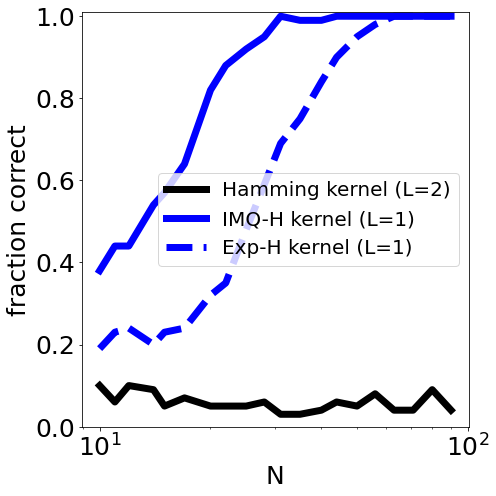

In [20]:
# plot results

plt.figure(figsize=[7, 7])
plt.semilogx(ns, np.average(p_vals_ham<0.05, axis=0),
             label='Hamming kernel (L=2)', color='black', lw=7)
plt.semilogx(ns, np.average(p_vals_imq<0.05, axis=0),
             label='IMQ-H kernel (L=1)', color='blue', lw=7)
plt.semilogx(ns, np.average(p_vals_exp<0.05, axis=0),
             label='Exp-H kernel (L=1)', color='blue', lw=7, ls='--')
plt.xlabel("N", fontsize=25)
plt.ylabel("fraction correct", fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(0, 1.01)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()
plt.close()